# Chronological Attribution of ancient texts using deep NNs

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import data_explore
import utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import torch
import torch.nn as nn


from datetime import datetime
from time import time


In [3]:
# Start time of Execution
time_start = time()

### Data Exploration & Preprocessing

In [8]:
# Retrieve data in DataFrame format
data = pd.read_csv('iphi2802.csv', sep= '\t')
df = pd.DataFrame(data)

#### Exploratory Data Analysis

In [6]:
df.head()

,id,text,metadata,region_main_id,region_main,region_sub_id,region_sub,date_str,date_min,date_max,date_circa
0,315181,[φ]ιλεταιρος ευμενου περγαμευς μουσαις. καφισι...,Boiotia — Thespiai — mid-3rd c. BC — BCH 26 (1...,1698,Central Greece (IG VII-IX),1691,"Megaris, Oropia, and Boiotia (IG VII)",mid-3rd c. BC,-275.0,-226.0,0.0
1,201686,μαλκοιδων ηρωνος.,"Crete, W. — Tarrha — 1st-3rd c. AD — IC II xxi...",1699,"Aegean Islands, incl. Crete (IG XI-[XIII])",474,Crete,1st-3rd c. AD,1.0,300.0,0.0
2,153178,βασιλικος.,Makedonia (Bottiaia) — Pella — 3rd/2nd c. BC —...,1692,Northern Greece (IG X),1485,Macedonia,3rd/2nd c. BC,-300.0,-101.0,0.0
3,28582,αισκλαπιει μ [ανεθεκε --].,Epidauria — Epidauros — sinistr. — 6th/5th c. BC,1690,Peloponnesos (IG IV-[VI]),1643,"Epidauria (IG IV²,1)",6th/5th c. BC,-600.0,-401.0,0.0
4,333620,[---]ος αν[εθηκε δαματρι].,Italia — Herakleia (Policoro) — late 4th/early...,1696,"Sicily, Italy, and the West (IG XIV)",1689,"Italy, incl. Magna Graecia",late 4th/early 3rd c. BC,-350.0,-251.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2802 entries, 0 to 2801
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2802 non-null   int64  
 1   text            2802 non-null   object 
 2   metadata        2802 non-null   object 
 3   region_main_id  2802 non-null   int64  
 4   region_main     2802 non-null   object 
 5   region_sub_id   2802 non-null   int64  
 6   region_sub      2802 non-null   object 
 7   date_str        2802 non-null   object 
 8   date_min        2802 non-null   float64
 9   date_max        2802 non-null   float64
 10  date_circa      2802 non-null   float64
dtypes: float64(3), int64(3), object(5)
memory usage: 240.9+ KB


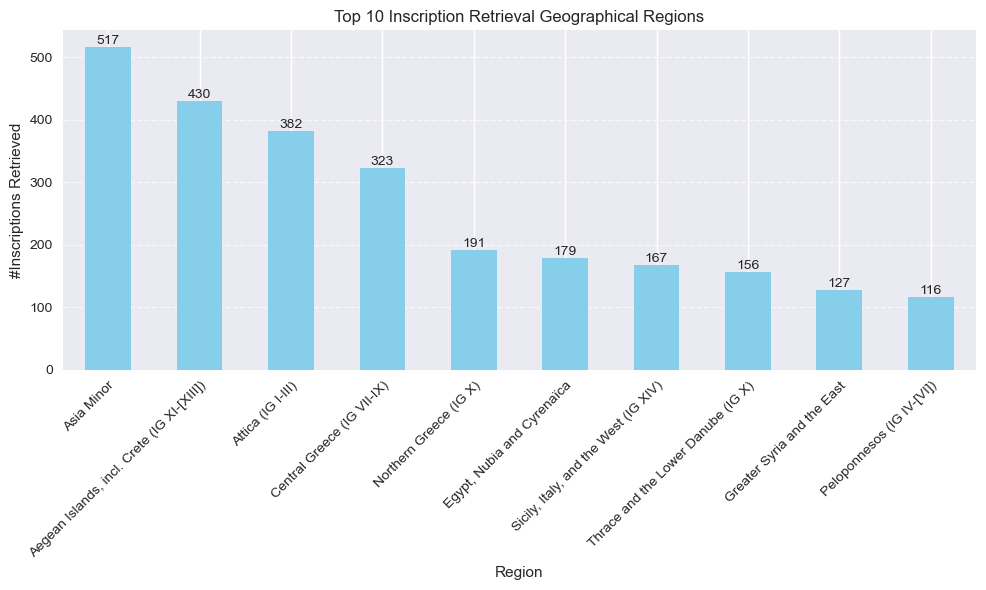

In [8]:
# Locations' dictionaries
region_main_dict = {key: value for key, value in zip(df['region_main_id'], df['region_main'])}
region_sub_dict = {key: value for key, value in zip(df['region_sub_id'], df['region_sub'])}
region_dict = {
    'region_main_dict': region_main_dict,
    'region_sub_dict': region_sub_dict
}
# Plot epigraph location frequency histogram
plt.figure(figsize=(10, 6))
bars = df['region_main_id'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Inscription Retrieval Geographical Regions')
plt.xlabel('Region')
plt.ylabel('#Inscriptions Retrieved')
plt.xticks(range(len(df['region_main_id'].value_counts().head(10))), [region_main_dict[key] for key in df['region_main_id'].value_counts().head(10).index], rotation=45, ha='right', rotation_mode='anchor')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom')

plt.tight_layout()

plt.show()

#### Data Preprocessing - Text Encoding (Tokenization/Vectorization) / Scaling

In [9]:
# extracting features - predictors
text = df['text']
region_main_id = df['region_main_id']
region_sub_id = df['region_sub_id']
# extracting labels
date_min  = df['date_min']
date_max = df['date_max']

# for usage on determing the features' selection in vectorization using ANOVA
df = df.assign(date_mean=(df['date_min'] + df['date_max']) / 2)
date_mean = df['date_mean']

labels_df = pd.DataFrame({
    'date_min': date_min,
    'date_max': date_max
})

Average number of words per sample: 7.0
Total number of ngrams: 81315


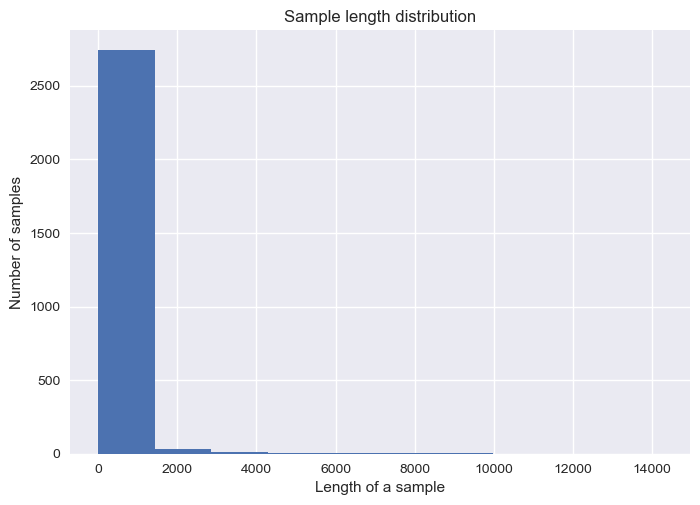

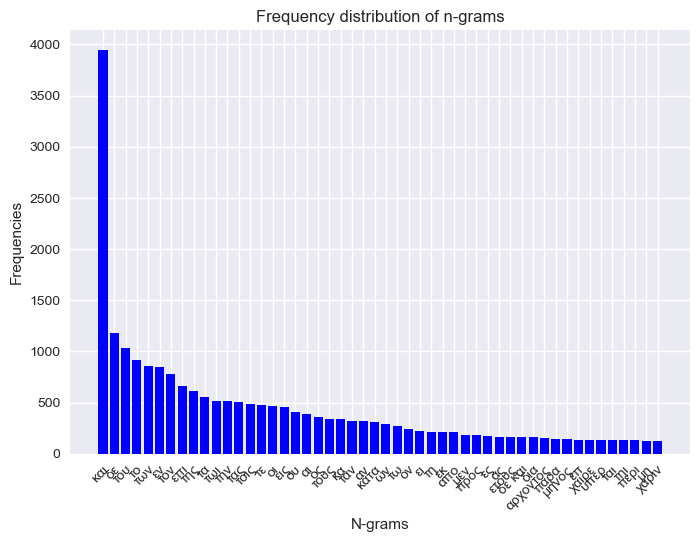

In [12]:
ave, ngrams = data_explore.get_num_words_per_sample(text)
print(f'Average number of words per sample: {ave}')
print(f'Total number of ngrams: {ngrams}')

# plot sample length distribution
data_explore.plot_sample_length_distribution(text)

# plot frequency distribution of ngrams
data_explore.plot_frequency_distribution_of_ngrams(text)

In [13]:
print(f'Total Samples / Average Number of Words per Sample = {2802/ave:.2f}')

Total Samples / Average Number of Words per Sample = 400.29


In [10]:
# Split data
X_train, X_test, labels_train, labels_test = train_test_split(text, labels_df, test_size=.3, random_state=42) 

In [11]:
# Get the indices of the samples in X_train
train_indices = X_train.index

# Select the corresponding date_mean values from the original dataframe
date_mean_train = df.loc[train_indices, 'date_mean']
date_mean_test = df.loc[~df.index.isin(train_indices), 'date_mean']

In [13]:
# Text vectorization
X_train_vect, X_test_vect = utils.ngram_vectorize(X_train, date_mean_train, X_test)

/Users/ioannisvelgakis/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:2077: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [14]:
print(f'Train Set size: {X_train_vect.shape}, Test Set size: {X_test_vect.shape}')

Train Set size: (1961, 623), Test Set size: (841, 623)


### Scaling

In [15]:
# Scaling labels
scaler = MaxAbsScaler()

# Fit scaler to new_df
scaler.fit(labels_train)

# Transform new_df using the scaler
scaled_labels_train = scaler.transform(labels_train)
scaled_labels_test = scaler.transform(labels_test)

# Create a new DataFrame with the scaled values
scaled_labels_train_df = pd.DataFrame(scaled_labels_train, columns=labels_train.columns)
scaled_labels_test_df = pd.DataFrame(scaled_labels_test, columns=labels_test.columns)

In [16]:

# Date Mean Scaling
# Instance of MaxAbsScaler
scaler = MaxAbsScaler()

# Reshape the date_mean column to a 2D array
date_mean_reshaped = date_mean.values.reshape(-1, 1)

# Fit the MaxAbsScaler to the date_mean column
scaler.fit(date_mean_reshaped)

# Transform the date_mean column using the fitted scaler
date_mean_scaled = scaler.transform(date_mean_reshaped)

# If you want to replace the original date_mean column with the scaled values
df['date_mean_scaled'] = date_mean_scaled
y_tr = df.loc[train_indices, 'date_mean_scaled']
y_te = df.loc[~df.index.isin(train_indices), 'date_mean_scaled']

In [85]:
y_train_min = scaled_labels_train_df['date_min']
y_train_max = scaled_labels_train_df['date_max']   

In [17]:
# Convert sparse matrix to dense array
X_train_dense = X_train_vect.toarray()
X_test_dense = X_test_vect.toarray()

In [39]:
X_train_dense.shape

(1961, 623)

# Neural Network

In [80]:
print(X_train_dense.shape)
print(y_tr.shape)

(1961, 623)
(1961,)


### 5-F CV ANN(623, 64, 1) using date_mean as target variable

Epoch 1/50


/Users/ioannisvelgakis/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0419 - val_mean_squared_error: 0.0419
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0375 - val_mean_squared_error: 0.0375
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0385 - val_mean_squared_error: 0.0385
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0397 - val_mean_squared_error: 0.0397
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0404 - val_mean_squared_error: 0.0404
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0417 - val_mean

/Users/ioannisvelgakis/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0425 - val_mean_squared_error: 0.0425
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0393 - val_mean_squared_error: 0.0393
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0394 - val_mean_squared_error: 0.0394
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0402 - val_mean_squared_error: 0.0402
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0408 - val_mean_squared_error: 0.0408
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0416 - val_mean_squared_error: 0.0416
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0420 - val_mean

/Users/ioannisvelgakis/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 0.0317 - val_mean_squared_error: 0.0317
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0321 - val_mean_squared_error: 0.0321
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 0.0336 - val_mean_squared_error: 0.0336
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.0251 - mean_squared_error: 0.0251 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0380 - val_mean

/Users/ioannisvelgakis/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0379 - val_mean_squared_error: 0.0379
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0346 - val_mean_squared_error: 0.0346
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 0.0272 - mean_squared_error: 0.0272 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.0273 - mean_squared_error: 0.0273 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0375 - val_mean

/Users/ioannisvelgakis/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0375 - val_mean_squared_error: 0.0375
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 0.0281 - mean_squared_error: 0.0281 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 0.0265 - mean_squared_error: 0.0265 - val_loss: 0.0363 - val_mean_squared_error: 0.0363
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0374 - val_mean_squared_error: 0.0374
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.0388 - val_mean

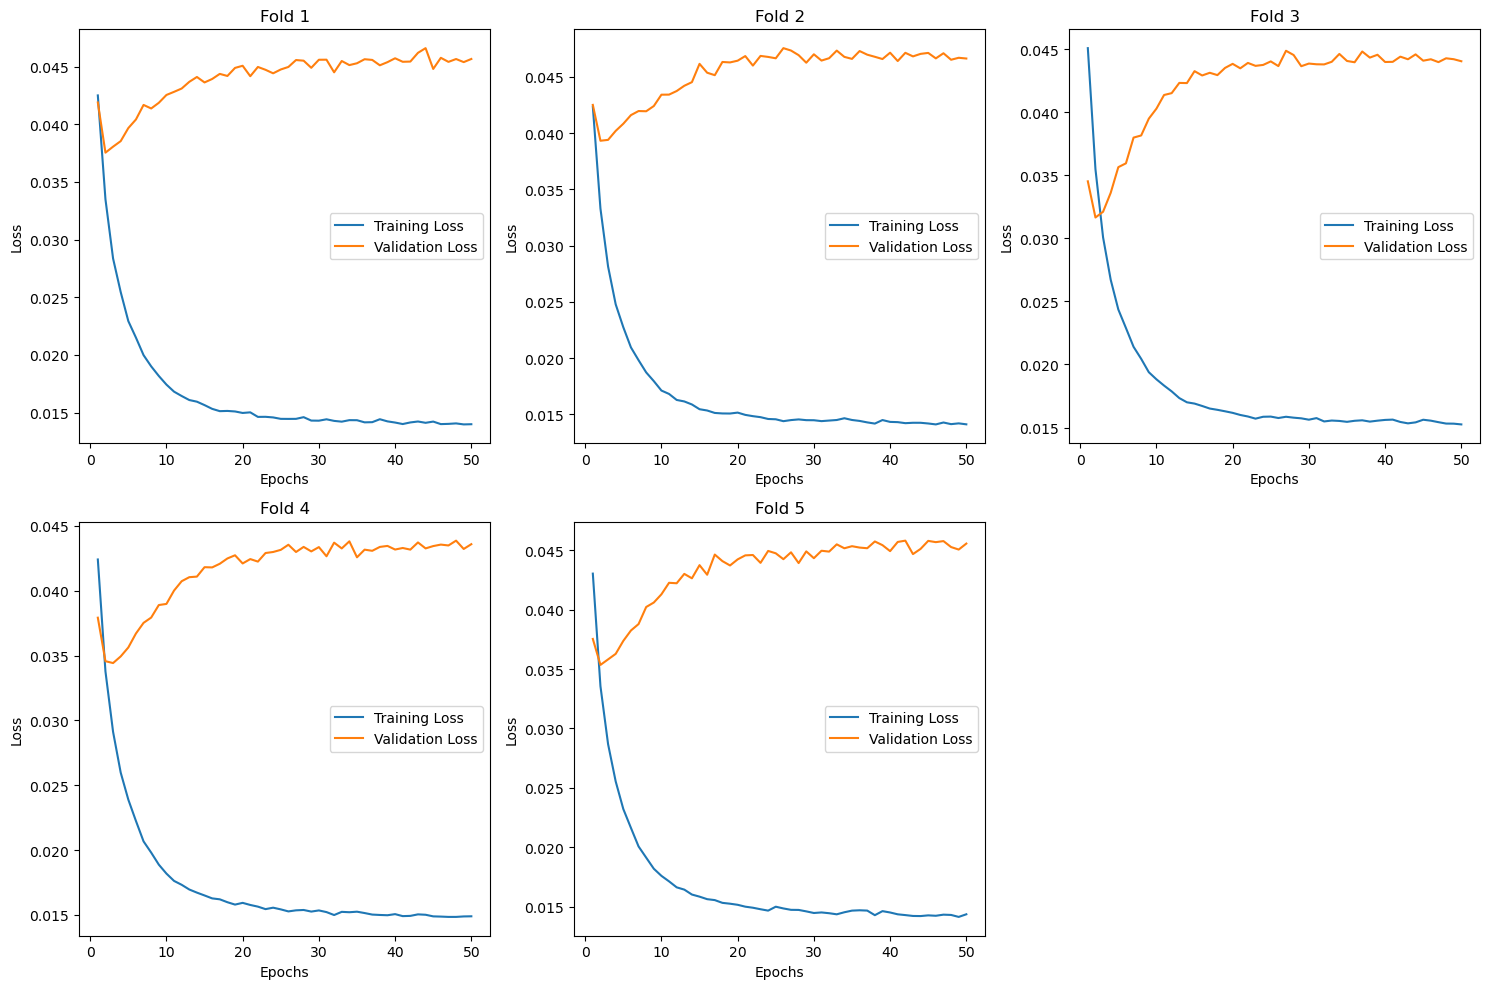

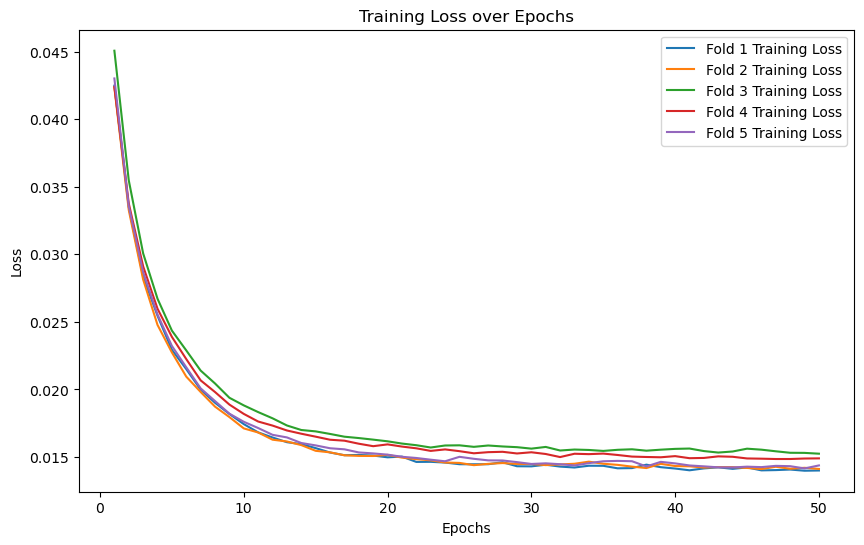

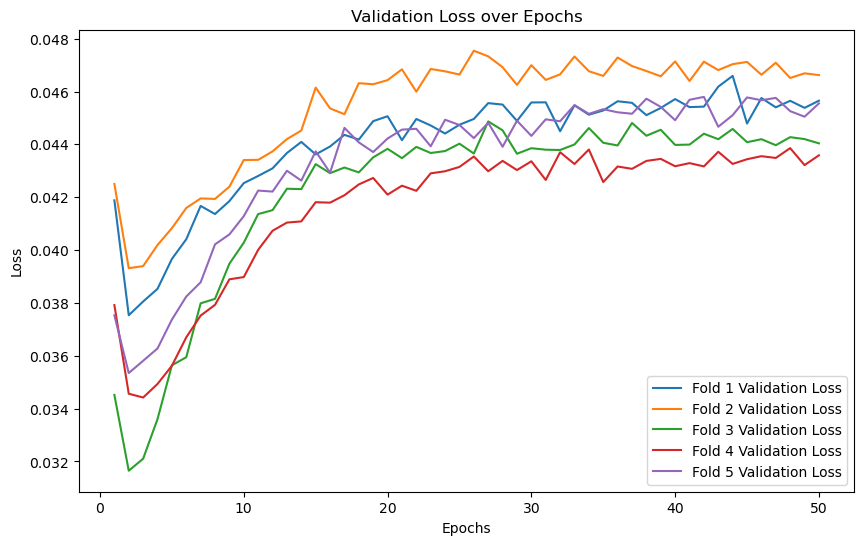

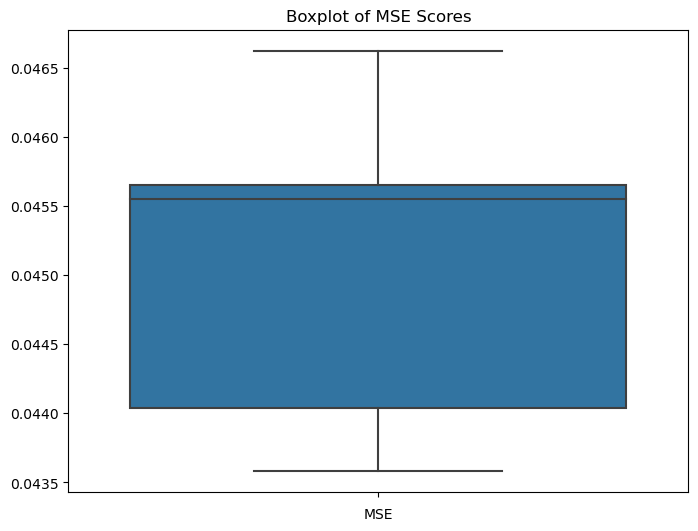

Mean MSE: 0.045089482631887945
Median MSE: 0.045549185331542466


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

# Define the number of folds
num_folds = 5

# Define the input dimensions
input_dim = 623

# Define the number of units in the hidden layer
hidden_units = 64

# Define the number of epochs and batch size
epochs = 50
batch_size = 20

# Define lists to store the MSE scores for each fold
mse_scores = []
loss_per_fold = []

# Define the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True)

# Define lists to store training and validation loss for each fold
train_loss_history = []
val_loss_history = []

# Iterate over the folds
for fold_no, (train_index, test_index) in enumerate(kf.split(X_train_dense), 1):
    # Split the data into training and testing sets
    X_train_fold, X_test_fold = X_train_dense[train_index], X_train_dense[test_index]
    y_train_fold, y_test_fold = y_tr.iloc[train_index], y_tr.iloc[test_index]
     
    # Create a new instance of the Sequential model
    model = Sequential()
    
    # Add the input layer and the first hidden layer, switch random uniform
    model.add(Dense(units=hidden_units, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    
    # Add the output layer
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

    # Fit data to model
    history = model.fit(X_train_fold, y_train_fold,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_test_fold, y_test_fold)) 
    
    # Append training and validation loss history
    train_loss_history.append(history.history['loss'])
    val_loss_history.append(history.history['val_loss'])
    
    # Evaluate the model on the testing data for the current fold
    scores = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    loss_per_fold.append(scores[0])
    
    # Calculate and store MSE for the current fold
    y_pred_fold = model.predict(X_test_fold)
    mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
    mse_scores.append(mse_fold)

# Plot training and validation loss for each fold
plt.figure(figsize=(15, 10))
for i in range(num_folds):
    plt.subplot(2, 3, i+1)
    plt.plot(range(1, epochs + 1), train_loss_history[i], label='Training Loss')
    plt.plot(range(1, epochs + 1), val_loss_history[i], label='Validation Loss')
    plt.title(f'Fold {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.tight_layout()
plt.show()

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
for i in range(num_folds):
    plt.plot(range(1, epochs + 1), train_loss_history[i], label=f'Fold {i+1} Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(num_folds):
    plt.plot(range(1, epochs + 1), val_loss_history[i], label=f'Fold {i+1} Validation Loss')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Boxplot of MSE scores
plt.figure(figsize=(8, 6))
sns.boxplot(y=mse_scores)
plt.title('Boxplot of MSE Scores')
plt.xlabel('MSE')
plt.show()

# Print mean and median MSE scores
print("Mean MSE:", np.mean(mse_scores))
print("Median MSE:", np.median(mse_scores))


In [94]:
def custom_rmse(y_pred, date):
    date_min = date[0][:]
    date_max = date[1][:]
    e1 = y_pred - date_min
    e2 = y_pred - date_max 
    if e1 * e2 <= 0:
        return 0
    else:
        return ((min(abs(e1), abs(e2))**2)/2)**0.5

In [18]:
# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=64, input_dim=623, kernel_initializer='normal', activation='relu'))
 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

/Users/ioannisvelgakis/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Fitting the ANN to the Training set USING DATE_MEAN
model.fit(X_train_dense, y_tr  ,batch_size = 32, epochs = 100, verbose=1)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.0201
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 0.0180
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.0177
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 0.0161
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 0.0166
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 0.0164
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 0.0173
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 0.0151
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 0.0151
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 0.0147
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 0.0156
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 0.0169
Epoch 13/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 0.0132
Epoch 14/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 0.0150
Epoch 15/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [21]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        39,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,005 (468.77 KB)

 Trainable params: 40,001 (156.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,004 (312.52 KB)

In [77]:
# Fitting the ANN to the Training set USING DATE_MEAN
model.fit(X_train_dense, y_tr ,batch_size = 32, epochs = 10, verbose=1)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 0.0175
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.0190
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 0.0159
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 0.0151
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 0.0173
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 0.0157
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 0.0172
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 0.0173
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 0.0161
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 0.0168


In [22]:
# Calculating the RMSE for all the samples in test set 
yhat = []
RMSE = []
sum = 0

# Iterate through the test set using enumerate to get both index and value
for i, x_test in enumerate(X_test_dense):
    # Predict the value for the current test sample
    prediction = model.predict(x_test.reshape(1, -1))
    
    # Append the predicted value to the yhat list
    yhat.append(prediction[0])
    
    # Calculate d1 and d2
    d1 = prediction[0] - scaled_labels_test_df.iloc[i, 0]
    d2 = prediction[0] - scaled_labels_test_df.iloc[i, 1]
    
    # Calculate the loss (MSE) and append it to the MSE list
    if d1 >= 0:
        if d2 <= 0:
            loss = 0
        else:
            loss = (((d2**2)/1)**.5)
    else:
        loss = (((d1**2)/1)**.5)
    RMSE.append(loss)
    sum += loss
    
    print(f'RMSE(pred{i}, y{i}): {loss}')
rmse_m = sum / X_test_dense.shape[0]
print(f'Mean RMSE: {rmse_m}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
RMSE(pred0, y0): [0.02716458]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE(pred1, y1): [0.05382616]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred2, y2): [0.34159714]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE(pred3, y3): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE(pred4, y4): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred5, y5): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred6, y6): [0.09741124]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred7, y7): [0.03560384]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred8, y8): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred9, y9): [0.03902467]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred10, y10): [0.11010642]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred11, y11): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred12, y12): [0.19784181]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred13, y13): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred14, y14): [0.07044396]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred15, 

list

In [21]:
# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=64, input_dim=623, kernel_initializer='normal', activation='relu'))
 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')
 
# Fitting the ANN to the Training set USING scaled_labels..
model.fit(X_train_vect, scaled_labels_train_df ,batch_size = 20, epochs = 50, verbose=1)

Epoch 1/50


/Users/ioannisvelgakis/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.0581
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.0441
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 0.0391
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 0.0327
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 0.0327
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 0.0298
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 0.0296
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 0.0281
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 0.0311
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 0.0249
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 0.0259
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 0.0247
Epoch 13/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 0.0264
Epoch 14/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 0.0250
Epoch 15/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 0.0276


In [ ]:
model.summary()

In [19]:
models = []
testrmse = []

#### Neural Network Architecture and Model Instantiation

#### NN Model Training

In [205]:
# Train the model
tf.data.experimental.enable_debug_mode()
history = model.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_val, y_val), verbose='auto')
# history = model.fit(T_train_scaled, labels_train, batch_size=16, epochs=10, validation_data=(T_test_scaled, labels_test), verbose='auto')

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5019 - mae: 1.1680 - val_loss: 1.7111 - val_mae: 1.0393
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0473 - mae: 0.7823 - val_loss: 1.4799 - val_mae: 1.0013
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7202 - mae: 0.6429 - val_loss: 1.7430 - val_mae: 1.0685
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5681 - mae: 0.5445 - val_loss: 1.4690 - val_mae: 0.9853
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6003 - mae: 0.5603 - val_loss: 1.5862 - val_mae: 1.0227
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5184 - mae: 0.4968 - val_loss: 1.4241 - val_mae: 0.9733
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5344 - mae: 0.4998 - val_loss: 1.6009 - val_mae: 1.0153
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5078 - mae: 0.4894 - val_loss: 1.4513 - val_mae: 0.9767
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

#### NN Model Evaluation

In [206]:
# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test.reshape(-1, *input_data_shape), y_test)
testmae += [test_mae]
print("Test Loss:", test_loss)
print("Test RMSE:", test_mae)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5998 - mae: 0.9451
Test Loss: 1.6118725538253784
Test RMSE: 0.9845868945121765


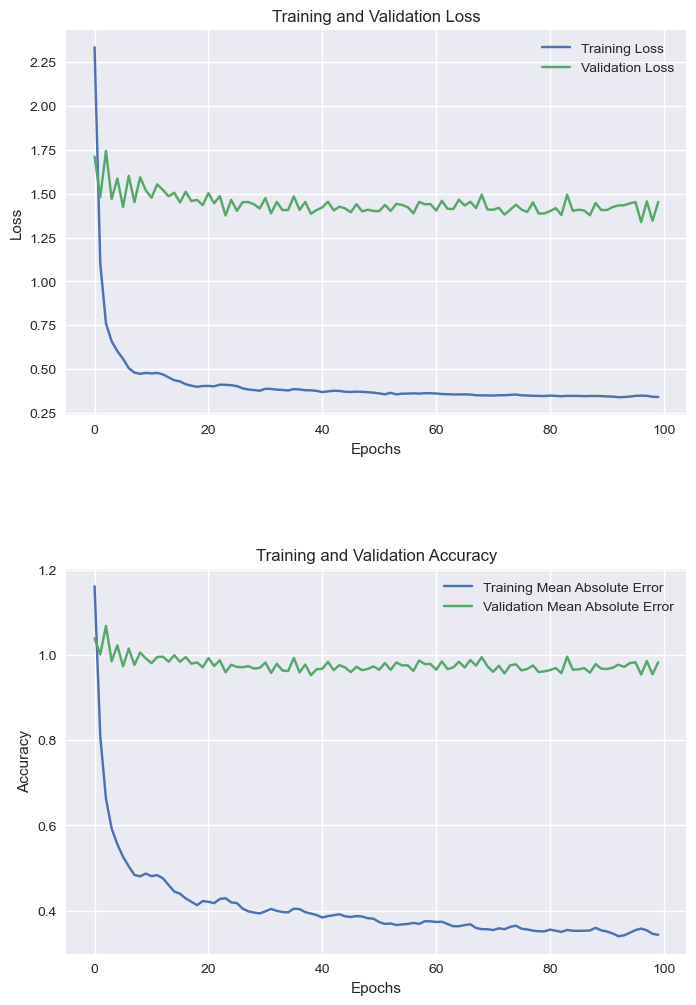

In [207]:
utils.plot_metrics(history)

In [192]:
print(f'Took {(time() - time_start) / 60:.2f} minutes!')

Took 84.94 minutes!
